In [1]:
import gymnasium as gym
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import imageio

# Random Agent

#### We are using the `Taxi-v3` environment from OpenAI's gym: https://gym.openai.com/envs/Taxi-v3/

#### `Taxi-v3` is an easy environment because the action space is small, and the state space is large but finite.

#### Environments with a finite number of actions and states are called tabular

#### Actions
There are 6 discrete deterministic actions:

- 0: move south

- 1: move north

- 2: move east

- 3: move west

- 4: pickup passenger

- 5: drop off passenger
#### Rewards
- -1 per step unless other reward is triggered.
- +20 delivering passenger.
- -10 executing “pickup” and “drop-off” actions illegally.

In [2]:
env=gym.make("Taxi-v3",  render_mode="rgb_array")

In [3]:
class RandomAgent:
    
    def __init__(self,env):
        self.env=env
        
    def get_Random_Action(self):
        return self.env.action_space.sample()
         

### create a random Agent interacting with "Taxi-v3" environment

In [4]:
agent = RandomAgent(env)

### Train the Random agent on multiples episodes

In [5]:
n_episodes = 100

# For plotting metrics
timesteps_per_episode = []
cumReward_per_episode = []
penalties_per_episode = []

for i in tqdm(range(0, n_episodes)):
    agent.env.reset()

    # initialize the metrics
    steps, penalties, cum_reward, = 0, 0, 0
    done = False

    while not done:

        # select an action randomly
        action = agent.get_Random_Action()

        next_state, reward, terminated, truncated, _ = agent.env.step(action)


        if reward == -10:
            penalties += 1
        else:
            cum_reward+=reward


        steps += 1

        done = terminated or truncated


    timesteps_per_episode.append(steps)
    cumReward_per_episode.append(cum_reward)
    penalties_per_episode.append(penalties)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 349.63it/s]


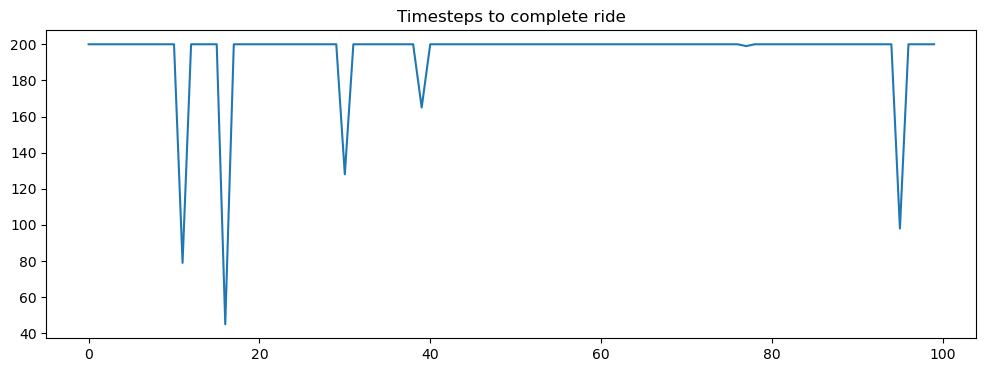

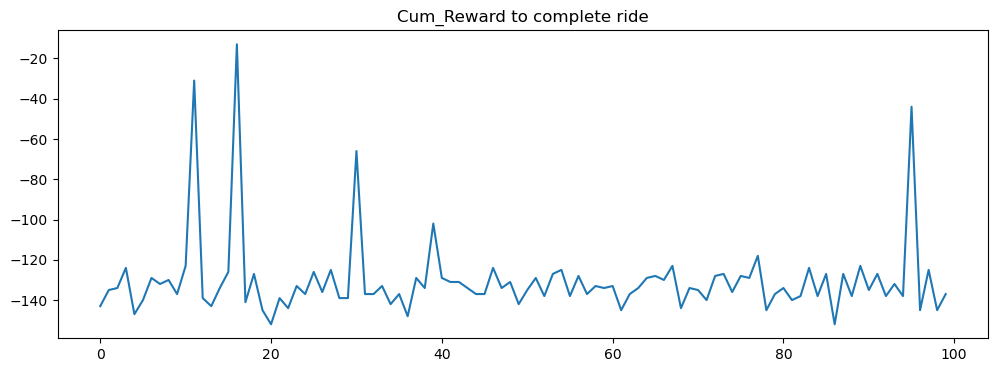

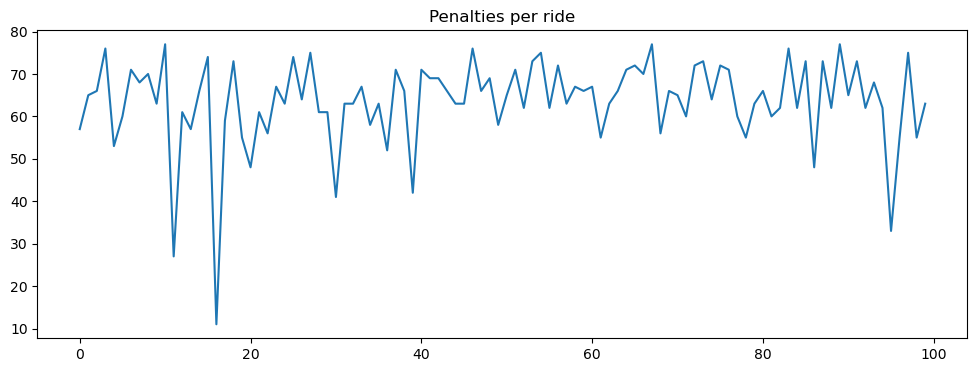

In [6]:

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")    
pd.Series(timesteps_per_episode).plot(kind="line")
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Cum_Reward to complete ride")    
pd.Series( cumReward_per_episode).plot(kind="line")
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")    
pd.Series(penalties_per_episode).plot(kind="line")
plt.show()

# Q-Learning

*Q-Learning* **is the RL algorithm that**:

- Trains *Q-Function*, an **action-value function** that encoded, in internal memory, by a *Q-table* **that contains all the state-action pair values.**

- Given a state and action, our Q-Function **will search the Q-table for the corresponding value.**

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit3/Q-function-2.jpg" alt="Q function"  width="100%"/>

- When the training is done,**we have an optimal Q-Function, so an optimal Q-Table.**

- And if we **have an optimal Q-function**, we
have an optimal policy, since we **know for, each state, the best action to take.**

In [7]:
env = gym.make("Taxi-v3",  render_mode="rgb_array")

In [8]:
env.observation_space.n * env.action_space.n

np.int64(3000)

### QAgent Class:
Is initialized with the environment *env* and the necessary hyper-parameters (*alpha*, *gamma*, *epsilon*, etc)

This class implements the most important steps of **Q-Learning** Algorithm:
-  Q-Table initialization
    -  Q-Table shape=(n_states * n_actions)

-  Epsilon-greedy policy as an acting policy
   - With *probability 1-ɛ* : **we do exploitation** (i.e. our agent selects the action with the highest state-action pair value).

   - With *probability ɛ*: we do **exploration** (trying a random action).

-  Greedy-policy as an updating policy
   - using Bellman equation *Q(s,a) + lr[R(s,a) + gamma * max Q(s',a') - Q(s,a)]*


In [9]:
class QAgent:

    def __init__(self, env, alpha, gamma, max_epsilon, min_epsilon, decay_rate):
       
        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros((self.env.observation_space.n, self.env.action_space.n))

        # hyper-parameters
        self.alpha = alpha                      # learning rate
        self.gamma = gamma                      # discount factor
        self.max_epsilon = max_epsilon          # Exploration probability at start
        self.min_epsilon = min_epsilon          # Minimum exploration probability
        self.decay_rate =  decay_rate           # Exponential decay rate for exploration prob
    

    
    # get action using epsilon greedy policy
    def get_action(self, state, epsilon):
        # Randomly generate a number between 0 and 1
        random_num = random.random()

        # if random_num > greater than epsilon --> exploitation
        if random_num > epsilon:
           # Take the action with the highest value given a state
           action = np.argmax(self.q_table, axis=1)[state]
    
        # else --> exploration
        else:
           action = self.env.action_space.sample()

        return action

    def update_parameters(self, state, action, reward, next_state):
        """"""
        # Q-learning formula
        # Update Q(s,a):= Q(s,a) + lr [R(s,a)  + gamma * max Q(s',a') - Q(s,a)]
        old_value = self.q_table[state][action]
        next_max = np.max(self.q_table[next_state]) 
        new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)

        # update the q_table
        self.q_table[state][action] = new_value

### The training loop:
The training is based on *Temporal Difference (TD) learning* where the Q-Table is updated after each step

- For episode in the total of training episodes:

  - Reduce epsilon (since we need less and less exploration)
  - Reset the environment

  - For step in max timesteps:
    - Choose the action $a$ using epsilon greedy policy
    - Take the action ($a$) and observe the outcome state(s') and reward (r)
    - Update the Q-value Q($s$,$a$) using Bellman equation Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    - If done, finish the episode
    - Our next state is the new state

In [10]:
def train(n_training_episodes, env, agent):

  episode_rewards = []
  episode_penalties = []
  episode_steps = []
  for episode in tqdm(range(n_training_episodes)):

    total_rewards_ep = 0
    total_penalties_ep=0
    total_steps_ep=0

    # Reduce epsilon (because we need less and less exploration)
    epsilon = agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon) * np.exp(-agent.decay_rate * episode)

    # Reset the environment
    state, info = env.reset()
    step = 0
    terminated = False
    truncated = False
    done=False

    # repeat
    while not done:
        # Choose the action At using epsilon greedy policy
        action = agent.get_action(state, epsilon)
        
        # Take action At and observe Rt+1 and St+1
        # Take the action (a) and observe the outcome state(s') and reward (r)
        next_state, reward, terminated, truncated, info = env.step(action)
        
        total_rewards_ep += reward
        total_steps_ep += 1
        if reward == -10:
            total_penalties_ep += 1
        
        # Update Q(s,a):= Q(s,a) + lr [R(s,a)  + gamma * max Q(s',a') - Q(s,a)]
        agent.update_parameters(state, action, reward, next_state)
        
        # If terminated or truncated finish the episode
        done = terminated or truncated
        
        if done:
            break
        
        # Our next state is the new state
        state = next_state 

    episode_rewards.append(total_rewards_ep)
    episode_steps.append(total_steps_ep)
    episode_penalties.append(total_penalties_ep)

  return  episode_rewards,episode_steps, episode_penalties

### Hyper-Parameters

The exploration related hyper-paramters are some of the most important ones.
- We need to make sure that our agent **explores enough of the state space** to learn a good value approximation. To do that, we need to have progressive decay of the epsilon.
- If you decrease epsilon too fast (too high decay_rate), **you take the risk that your agent will be stuck**, since your agent didn't explore enough of the state space and hence can't solve the problem.

In [11]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
alpha= 0.7                   # Learning rate

# Environment parameters
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005           # Exponential decay rate for exploration prob

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

### Train the Q-Agent on Taxiv3 Environment

In [12]:
env=gym.make("Taxi-v3", render_mode="rgb_array")

agent = QAgent(env, alpha, gamma, max_epsilon, min_epsilon, decay_rate)

episode_rewards,episode_steps, episode_penalties=train(n_training_episodes, env,agent)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1744.23it/s]


### Plot the training result
- episode_rewards: the cumulative rewards progression over all episodes (should increase over time)
- episode_steps: the required step per episode (should decrease over time)
- episode_penalties: the total penalties per episode (should decrease over time)

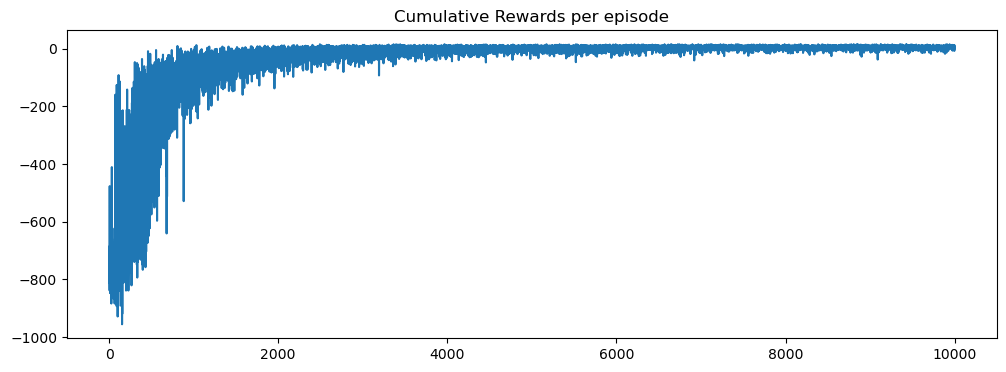

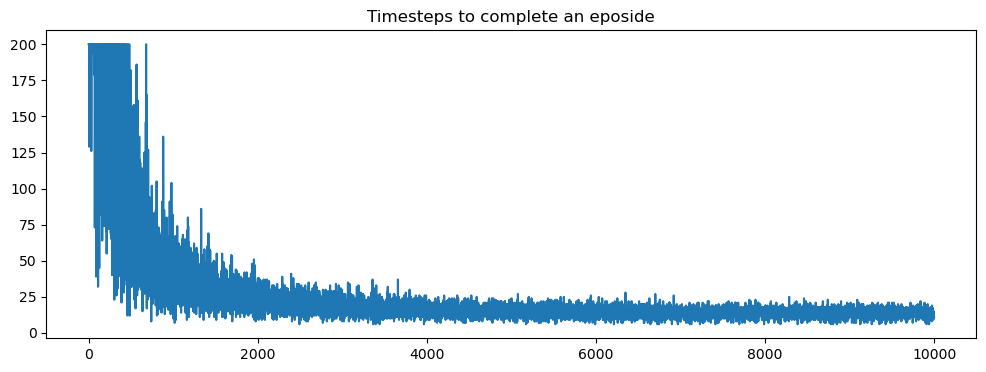

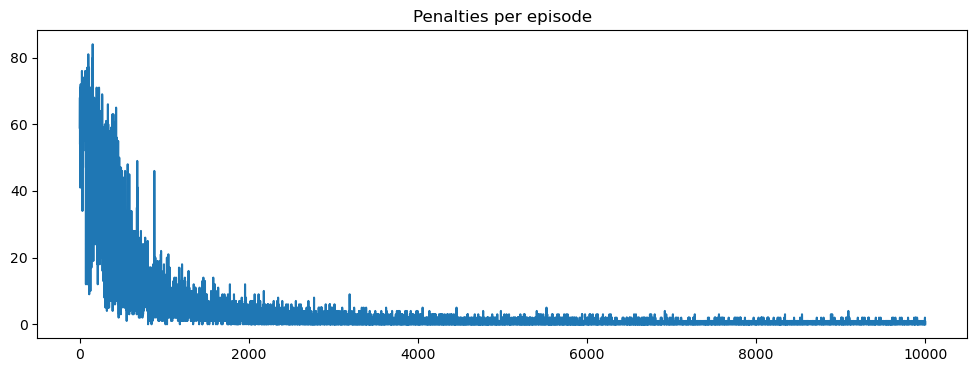

In [14]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Cumulative Rewards per episode")
pd.Series(episode_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete an eposide")
pd.Series(episode_steps).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per episode")
pd.Series(episode_penalties).plot(kind='line')
plt.show()

### Evaluate the QAgent after training

In [15]:
def evaluate_agent(env,agent,  n_eval_episodes):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param agent: the gent within its  evaluation environment and Qtable
  :param max_steps: Maximum number of steps per episode
  :param n_eval_episodes: Number of episode to evaluate the agent
   """
  episode_rewards = []
  episode_penalties = []
  episode_steps = []
  for episode in tqdm(range(n_eval_episodes)):

    state, info= env.reset()
    step = 0
    truncated = False
    terminated = False
    total_rewards_ep = 0
    total_penalties_ep=0
    total_steps_ep=0
    done= False

    while not done:
      # Take the action (index) that have the maximum expected future reward given that state
      # we use epsilon=0 for exploitation

      action = agent.get_action(state,0)
      next_state, reward, terminated, truncated, info = env.step(action)

      total_rewards_ep += reward
      total_steps_ep+=1

      if reward == -10:
            total_penalties_ep += 1

      done=terminated or truncated

      if done:
        break

      state = next_state

    episode_rewards.append(total_rewards_ep)
    episode_steps.append(total_steps_ep)
    episode_penalties.append(total_penalties_ep)

  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward, episode_rewards,episode_steps, episode_penalties

In [16]:
mean_reward, std_reward,episode_rewards,episode_steps, episode_penalties=evaluate_agent(env,agent, 1000)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3852.52it/s]

Mean_reward=7.89 +/- 2.61


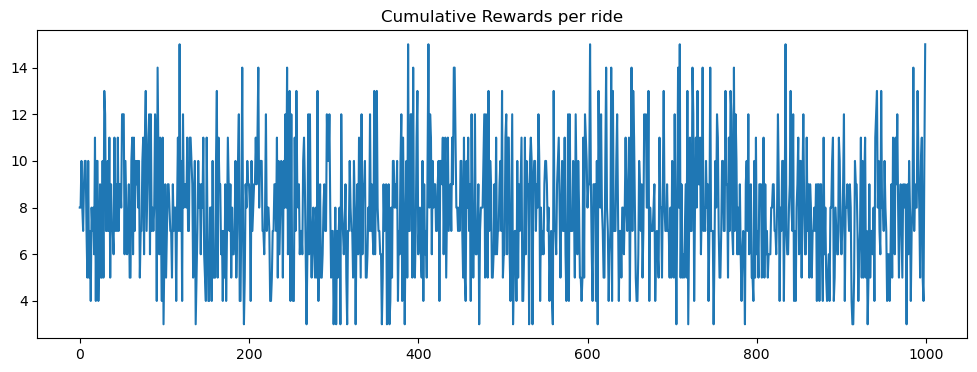

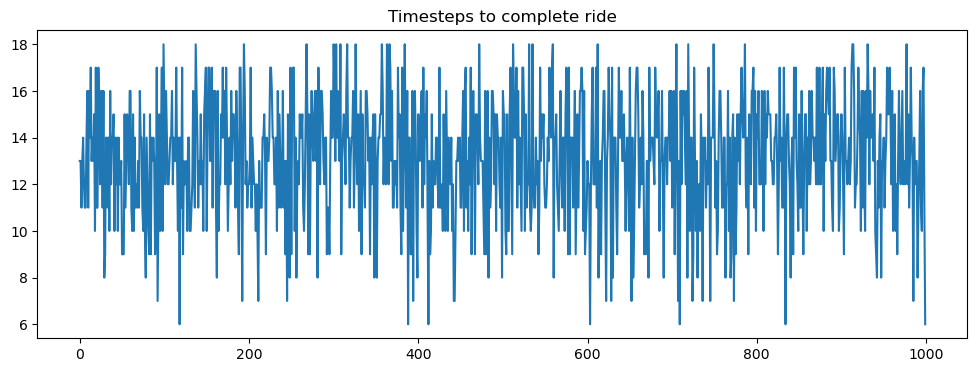

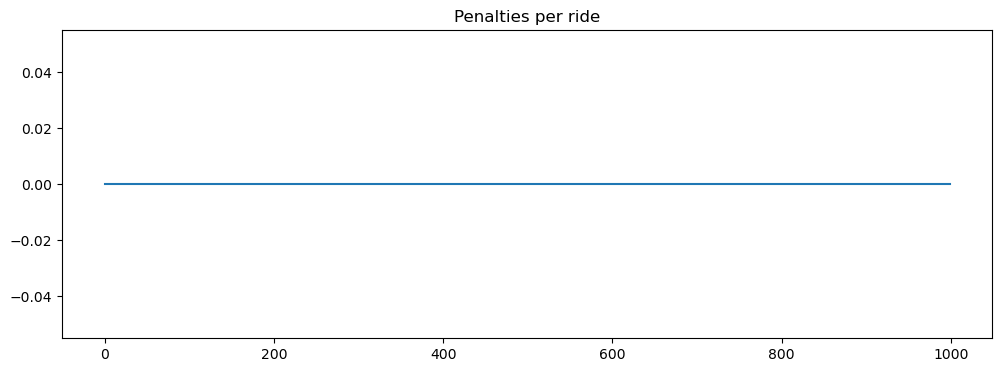

In [17]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Cumulative Rewards per ride")
pd.Series(episode_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")
pd.Series(episode_steps).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")
pd.Series(episode_penalties).plot(kind='line')
plt.show()

### Record a simulation as a video

In [18]:
def record_video(env, agent, out_directory, fps=1):
  """
  Generate a replay video of the agent
  :param env
  :param agent:  agent within its Qtable
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  terminated = False
  truncated = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(agent.q_table[state][:])
    state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [20]:
from base64 import b64encode
from IPython.display import HTML

# generate the video
video_path = "./replay.mp4"
record_video(env, agent, video_path, 1)

# Show video
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=400 controls>      <source src="%s" type="video/mp4"></video>""" % data_url)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# SARSA

In [21]:
class SARSA_Agent:

    def __init__(self, env, alpha, gamma, max_epsilon, min_epsilon, decay_rate):

        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table=np.zeros((env.observation_space.n, env.action_space.n))

        # hyper-parameters
        self.alpha = alpha                      # learning rate
        self.gamma = gamma                      # discount factor
        self.max_epsilon = max_epsilon          # Exploration probability at start
        self.min_epsilon = min_epsilon          # Minimum exploration probability
        self.decay_rate =  decay_rate           # Exponential decay rate for exploration prob



    # get action using epsilon greedy polic
    def get_action(self, state, epsilon):
        # Randomly generate a number between 0 and 1
        random_num =random.uniform(0,1)

        # if random_num > greater than epsilon --> exploitation
        if random_num > epsilon:
           # Take the action with the highest value given a state
           # np.argmax can be useful here
           action = np.argmax(self.q_table[state])

        # else --> exploration
        else:
           action = self.env.action_space.sample()

        return action

    def update_parameters(self, state, action, reward, next_state,epsilon):
        """"""
        # SARSA-learning formula
        # Update Q(s,a):= Q(s,a) + lr [R(s,a)  + gamma * Q(s',a') - Q(s,a)]
        old_value = self.q_table[state][action]#--- add code here----------
        next_action = self.get_action(next_state, epsilon)
        next_max = self.q_table[next_state][next_action] 
        new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)
         #--- add code here (4 lines)----------

        # update the q_table
        self.q_table[state, action] = new_value
        return next_action

In [22]:
def train(n_training_episodes, max_steps, env, agent):

  episode_rewards = []
  episode_penalties = []
  episode_steps = []
  for episode in tqdm(range(n_training_episodes)):

    total_rewards_ep = 0
    total_penalties_ep=0
    total_steps_ep=0

    # Reduce epsilon (because we need less and less exploration)
    epsilon = agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon)*np.exp(-agent.decay_rate*episode)

    # Reset the environment
    state, info = env.reset()
    step = 0
    terminated = False
    truncated = False
    done=False

    action = agent.get_action(state, epsilon)

    # repeat
    while not done:
      # Choose the action At using epsilon greedy policy
      

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      next_state, reward, terminated, truncated, info = env.step(action)

      total_rewards_ep += reward
      total_steps_ep +=1
      if reward == -10:
            total_penalties_ep += 1

      # Update Q(s,a):= Q(s,a) + lr [R(s,a)  + gamma * Q(s',a') - Q(s,a)]
      action = agent.update_parameters(state, action, reward, next_state, epsilon)
      # If terminated or truncated finish the episode
      done=terminated or truncated

      if done:
        break

      # Our next state is the new state
      state = next_state

      episode_rewards.append(total_rewards_ep)
      episode_steps.append(total_steps_ep)
      episode_penalties.append(total_penalties_ep)

  return  episode_rewards,episode_steps, episode_penalties


In [23]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
alpha= 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

In [24]:
#env=gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")
env=gym.make("Taxi-v3", render_mode="rgb_array")

agent=SARSA_Agent(env, alpha, gamma, max_epsilon, min_epsilon, decay_rate)

episode_rewards,episode_steps, episode_penalties=train(n_training_episodes, max_steps, env,agent)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1216.86it/s]


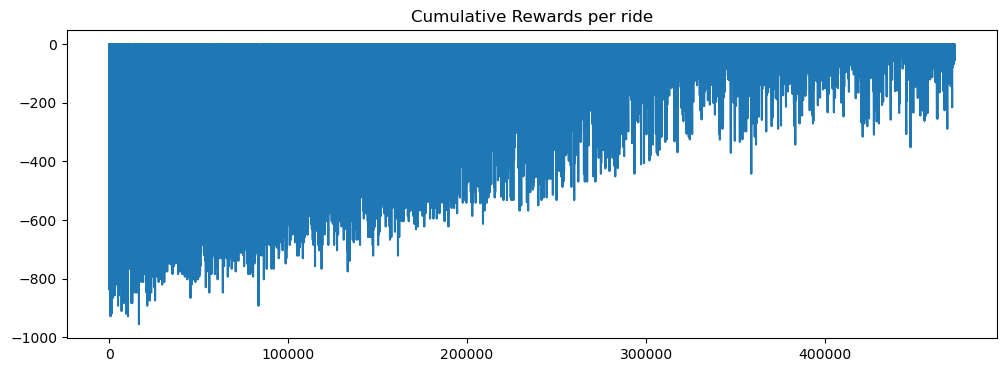

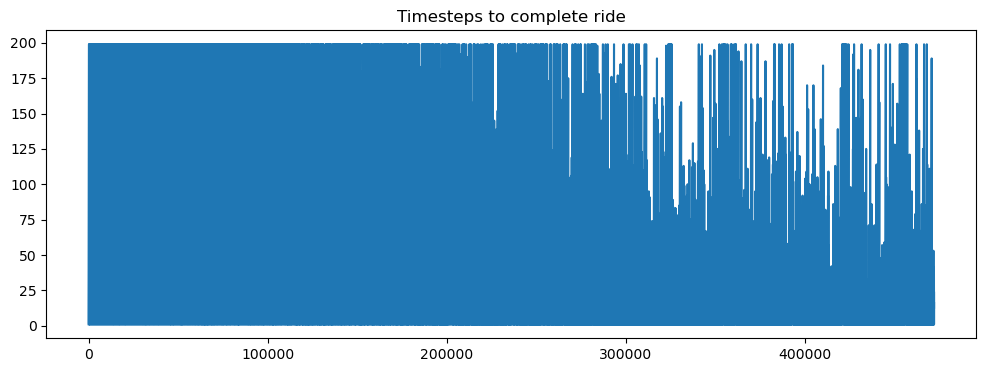

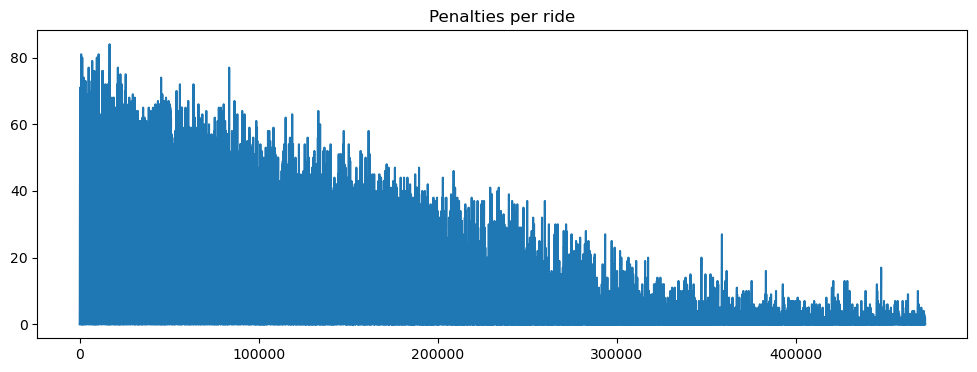

In [25]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Cumulative Rewards per ride")
pd.Series(episode_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")
pd.Series(episode_steps).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")
pd.Series(episode_penalties).plot(kind='line')
plt.show()

### Evaluate the QAgent after training

In [26]:
def evaluate_agent(env,agent,  n_eval_episodes):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param agent: the gent within its  evaluation environment and Qtable
  :param max_steps: Maximum number of steps per episode
  :param n_eval_episodes: Number of episode to evaluate the agent
   """
  episode_rewards = []
  episode_penalties = []
  episode_steps = []
  for episode in tqdm(range(n_eval_episodes)):

    state, info= env.reset()
    step = 0
    truncated = False
    terminated = False
    total_rewards_ep = 0
    total_penalties_ep=0
    total_steps_ep=0
    done= False

    while not done:
      # Take the action (index) that have the maximum expected future reward given that state
      # we use epsilon=0 for exploitation

      action = agent.get_action(state,0)
      next_state, reward, terminated, truncated, info = env.step(action)

      total_rewards_ep += reward
      total_steps_ep+=1

      if reward == -10:
            total_penalties_ep += 1

      done=terminated or truncated

      if done:
        break

      state = next_state

    episode_rewards.append(total_rewards_ep)
    episode_steps.append(total_steps_ep)
    episode_penalties.append(total_penalties_ep)

  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward, episode_rewards,episode_steps, episode_penalties

In [27]:
mean_reward, std_reward,episode_rewards,episode_steps, episode_penalties=evaluate_agent(env,agent, 1000)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1642.99it/s]

Mean_reward=-32.34 +/- 81.78


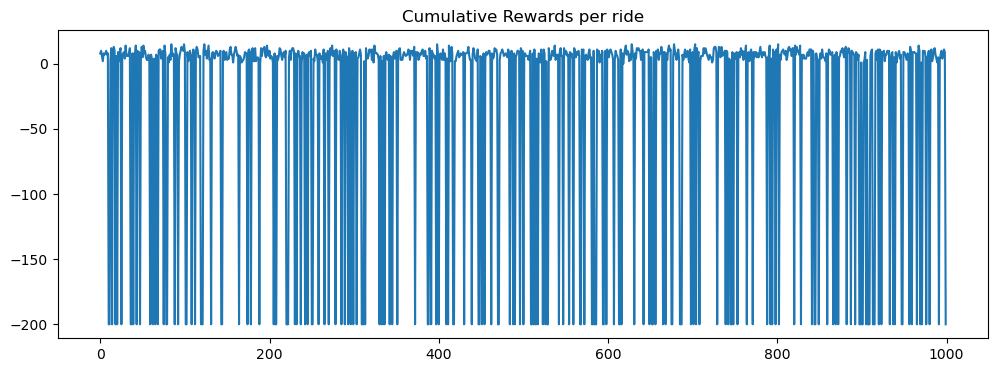

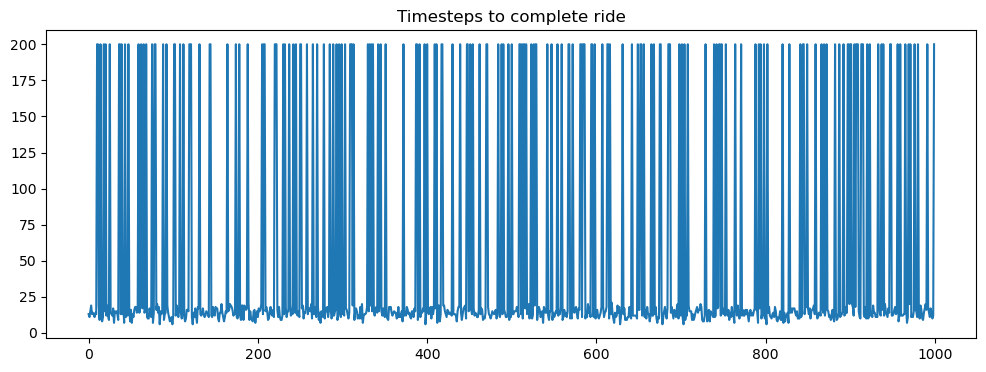

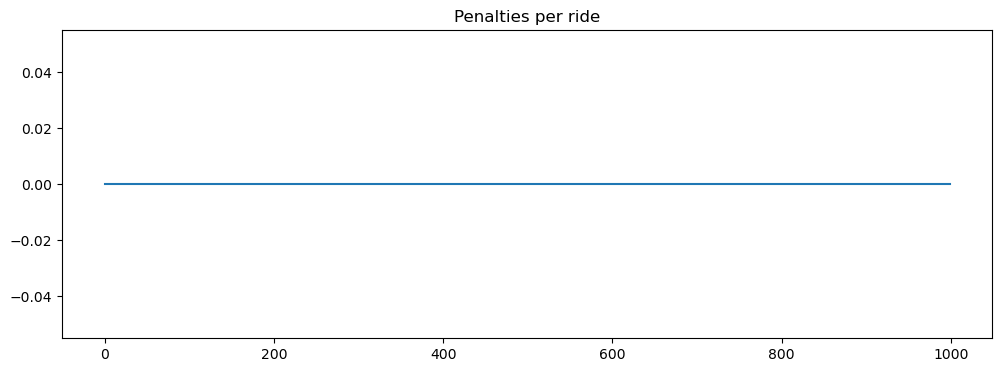

In [28]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Cumulative Rewards per ride")
pd.Series(episode_rewards).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")
pd.Series(episode_steps).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")
pd.Series(episode_penalties).plot(kind='line')
plt.show()

### Record a simulation as a video

In [30]:
def record_video(env, agent, out_directory, fps=1):
  """
  Generate a replay video of the agent
  :param env
  :param agent:  agent within its Qtable
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  terminated = False
  truncated = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(agent.q_table[state][:])
    state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [31]:

from base64 import b64encode
from IPython.display import HTML

# generate the video
video_path = "./replay.mp4"
record_video(env, agent, video_path, 1)

# Show video
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=400 controls>      <source src="%s" type="video/mp4"></video>""" % data_url)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
